# Ejercicio análisis time series
Para este ejercicio vas a trabajar con el histórico de valores en bolsa de una empresa que se dedica a vender muebles. Se pide
1. Importa los datos 'df_furniture.csv'
2. Trata la fecha como texto. Crea una columna para el año, mes y dia, y a partir de esas columnas crea la de fecha, en formato datetime de pandas
3. ¿De qué fecha a qué fecha va el histórico?
4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?
5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?
6. Parece que hay una tendencia, pero no se aprecia bien con tanto pico en la serie. ¿Conoces algún método para representar mejor la tendencia?
7. Estaría bien visualizar todos los componentes de la serie temporal por separado
8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional
9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación. ¿Esto es bueno para los modelos?
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Cargamos los datos

In [69]:
df = pd.read_csv('data/df_furniture.csv')
df.tail(20)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     326 non-null    object 
 1   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


In [73]:
df = pd.read_csv('data/df_furniture.csv')
df['value'] = df['furniture_price_adjusted']
df.drop('furniture_price_adjusted', 1, inplace=True)

all_dates = pd.date_range(start='1992-01-01',
              end='2019-07-01',
              freq='MS')

#df_dates = pd.DataFrame(all_dates, columns=['Month'])
df['Month'] = all_dates
df.set_index(df['Month'], inplace=True)
df.drop(columns=['Month'], inplace=True)
df.head()

,value
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


## 2. Tratar la fecha como texto y parsear

In [48]:
df2 = df.copy()
df2['date'] = df.index
df2['date'] = df2['date'].astype(str)

df2[['year', 'month', 'day']] = df2['date'].str.split('-', expand=True)
df2['year'] = df2['year'].astype(int)
df2['month'] = df2['month'].astype(int)
df2['day'] = df2['day'].astype(int)

df2['new_date'] = pd.to_datetime(df2[['year', 'month', 'day']])
df2.head()

,value,date,year,month,day,new_date
Month,,,,,,
1992-01-01,2073.432724,1992-01-01,1992,1,1,1992-01-01
1992-02-01,2114.485812,1992-02-01,1992,2,1,1992-02-01
1992-03-01,2260.570891,1992-03-01,1992,3,1,1992-03-01
1992-04-01,2255.103236,1992-04-01,1992,4,1,1992-04-01
1992-05-01,2331.414618,1992-05-01,1992,5,1,1992-05-01


## 3. ¿De qué fecha a qué fecha va el histórico?

La serie va desde enero de 1992 a julio de 2019

In [49]:
print(df.index.values.min())
print(df.index.values.max())

1992-01-01
2019-07-01


## 4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?

Se ve que tiene una clara tendencia al alza, a pesar de una pequeña bajada en als acciones en el 2007.

También apreciamos estacionalidad, al cumplirse cierto patrón a lo largo del tiempo

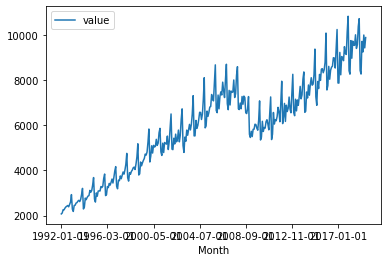

In [50]:
df.plot();

## 5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?

In [51]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
adfuller(df.value.values)[1]

0.7035529748090005

In [52]:
df[0:int(len(df)/2)].describe()

,value
count,165.000000
mean,4366.695881
std,1412.738867
min,2073.432724
25%,3115.400080
50%,4275.168742
75%,5428.334524
max,8110.153770


In [53]:
df[int(len(df)/2):].describe()

,value
count,166.000000
mean,7575.142501
std,1270.370560
min,5349.481724
25%,6613.056182
50%,7345.578004
75%,8439.580036
max,10833.501852


## 6. ¿Conoces algún método para representar mejor la tendencia?

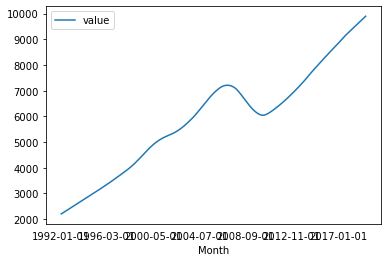

In [54]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

df_loess_15 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.15)[:, 1], index=df.index, columns=['value'])
df_loess_15.plot();

## 7. Estaría bien visualizar todos los componentes de la serie temporal por separado

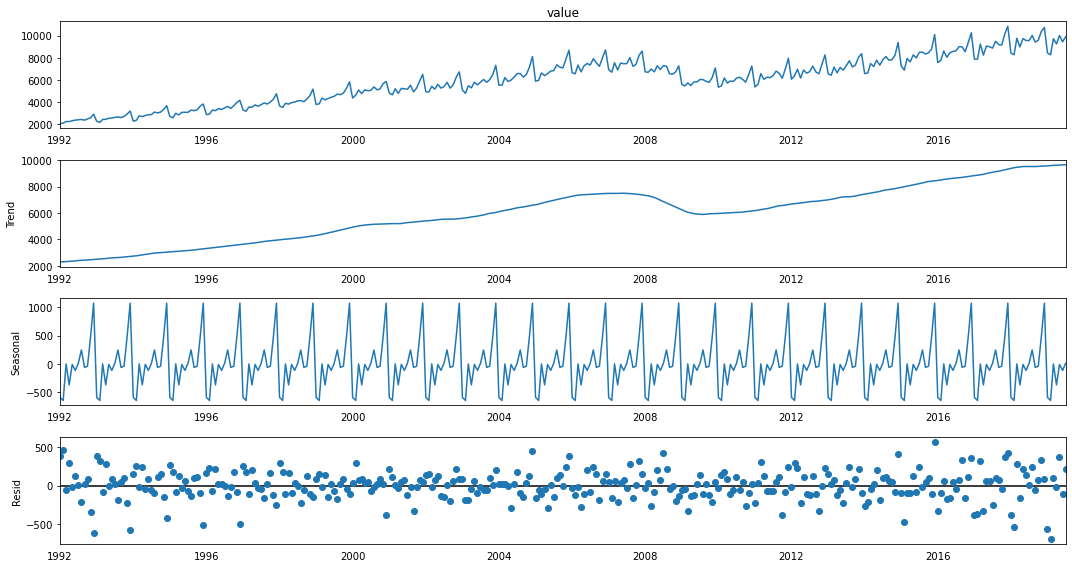

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (15,8)})
result_add.plot()
plt.show()

## 8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional

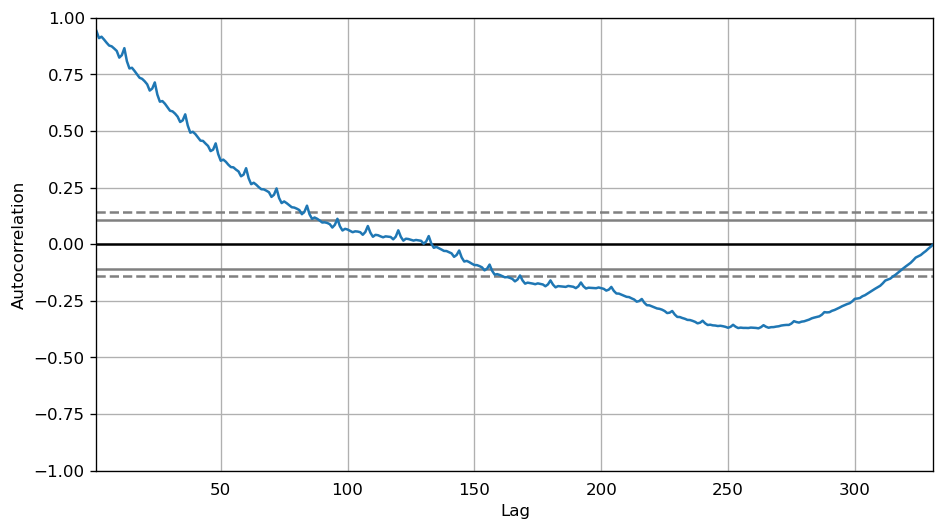

In [56]:
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist());

## 9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuestralo mediante una matriz de correlación.

In [93]:
df2 = df[['value']].copy()
df2['lag1'] = df2['value'].shift(1)
df2['lag2'] = df2['value'].shift(2)
df2['lag3'] = df2['value'].shift(3)
df2['lag4'] = df2['value'].shift(4)
df2['lag5'] = df2['value'].shift(5)
df2.corr()

,value,lag1,lag2,lag3,lag4,lag5
value,1.000000,0.951005,0.928338,0.945035,0.940613,0.935901
lag1,0.951005,1.000000,0.950599,0.927538,0.944637,0.939980
lag2,0.928338,0.950599,1.000000,0.950224,0.926949,0.944155
lag3,0.945035,0.927538,0.950224,1.000000,0.949927,0.926156
lag4,0.940613,0.944637,0.926949,0.949927,1.000000,0.949554
lag5,0.935901,0.939980,0.944155,0.926156,0.949554,1.000000


In [ ]:
from pandas.plotting import lag_plot

lag_plot(df['value']);

## 10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

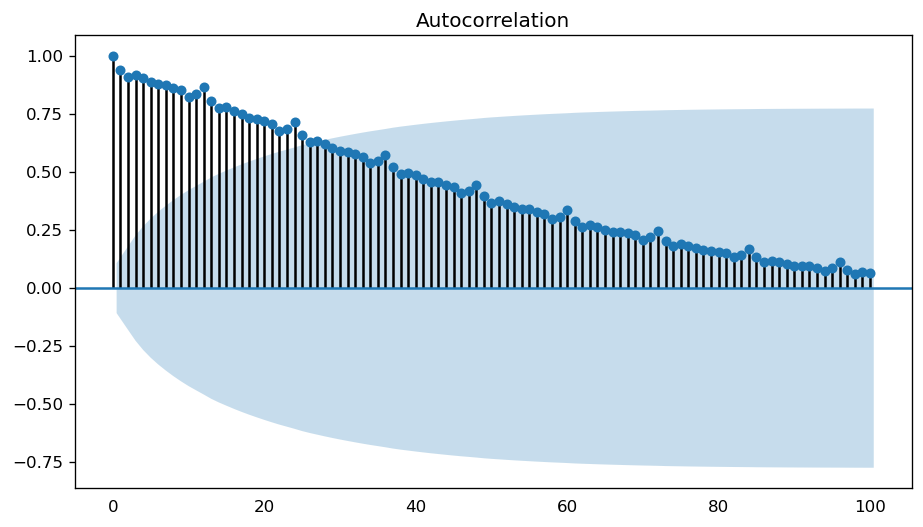

In [90]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(df['value'], lags=100);

## 11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

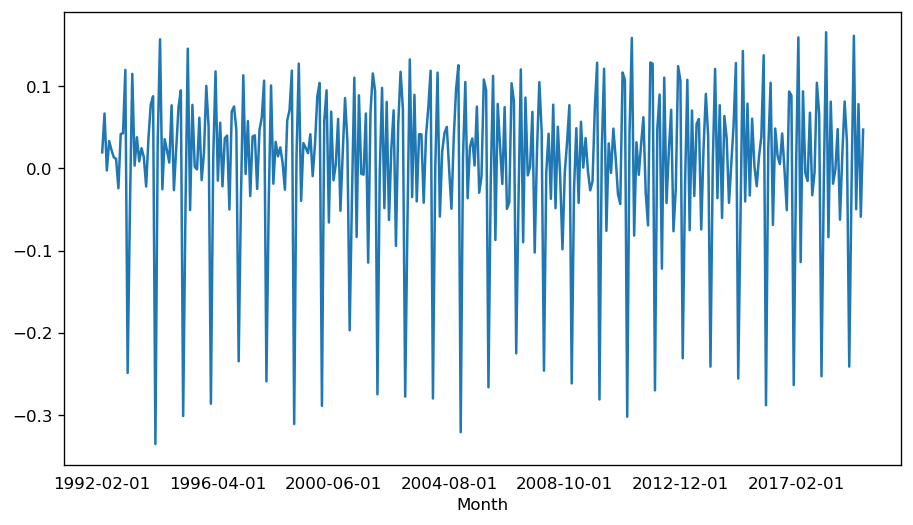

In [100]:
diferencio = np.log(df['value']).diff(1).dropna()

diferencio.plot();